In [296]:
import numpy as np
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp

import os, sys
sys.path.insert(0, os.path.abspath(".."))
from Utils.plotting import plot

A simple dynamical system in Parareal:
\begin{align}
\frac{du}{dt} &= A u \qquad t \in [0, 1], \text{ and }  A &= 
\begin{pmatrix}
0 & 1 \\
-1 & 0
\end{pmatrix} \\
u(0) &= 10
\end{align}


## Define the propagators

In [297]:
# @jax.jit
def f(t, y):
    A = jnp.array([[0, 1], [-1, 0]])
    return A@y

def coarse_integrator(DT, y0, n_steps=10, t_s=0., get_sol=False):
    t = jnp.linspace(t_s, t_s+DT, n_steps)
    dT = t[1]-t[0]

    y_list = []
    y = y0
    for i in range(n_steps):
        y_list.append(y)
        y += dT * f(t[i], y)

    if get_sol:
        return t, jnp.array(y_list).T
    else:
        return y

def fine_integrator(DT, y0, n_steps=10, t_s=0., get_sol=False):
    """N.B. As opposed to the coarse integrator, N does not indicate the fineness of the results"""
    eps = 1e-5  # we want to evaluate the solution at t_e too
    t_span = (t_s, t_s+DT+eps)
    t_eval = jnp.linspace(t_s, t_s+DT, n_steps) if get_sol else None
    sol = solve_ivp(fun=f, y0=y0, t_span=t_span, t_eval=t_eval, method='DOP853')

    if get_sol:
        return sol.t, sol.y
    else:
        return sol.y[:, -1]

Test the integrators on the entire domain

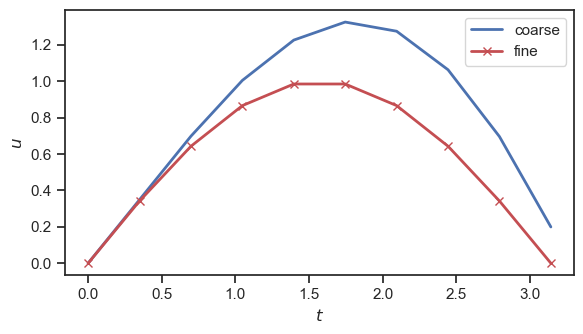

In [317]:
T = jnp.pi
u0 = jnp.array([0., 1.])

t, u_tilde = coarse_integrator(T, u0, n_steps=10, get_sol=True)
ax = plot(t, u_tilde[0], label="coarse")

t, u_hat = fine_integrator(T, u0, n_steps=10, get_sol=True)
plot(t, u_hat[0], "rx-", ax=ax, label="fine", x_label=r"$t$", y_label=r"$u$");

Test the fine integrator sequentially as multiple initial value problems.

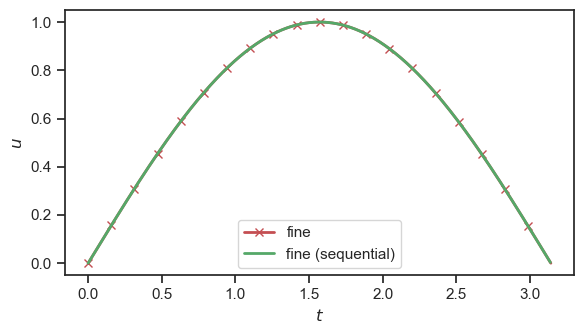

In [335]:
N = 10 ## number of precessors
DT = T/N

u_ = u0[:, jnp.newaxis]
t_ = jnp.array([0.0])
t_seq = []
u_hat_seq = []
for n in range(N):
    t_, u_ = fine_integrator(DT, u_[:, -1], n_steps=101, get_sol=True, t_s=t_[-1])
    u_hat_seq.append(u_[:, :-1])
    t_seq.append(t_[:-1])

t, u_hat = fine_integrator(T, u0, n_steps=1000, get_sol=True)
ax = plot(t, u_hat[0], "rx-", markevery=50, label="fine", x_label=r"$t$", y_label=r"$u$")

t_seq = jnp.concatenate(t_seq)
u_hat_seq = jnp.concatenate(u_hat_seq, axis=1)
ax = plot(t_seq, u_hat_seq[0], "g-", label="fine (sequential)", ax=ax);
# print('shapes:', u_hat_seq.shape, u_hat.shape)

## Parareal algorithm

In [329]:
K_max = 5